In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
41378,NaN,NaN,International,2020-09-01,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41379,NaN,NaN,International,2020-09-02,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41380,NaN,NaN,International,2020-09-03,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


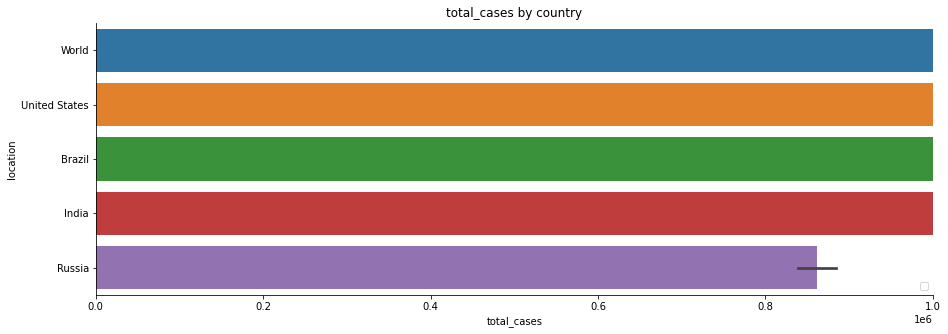

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


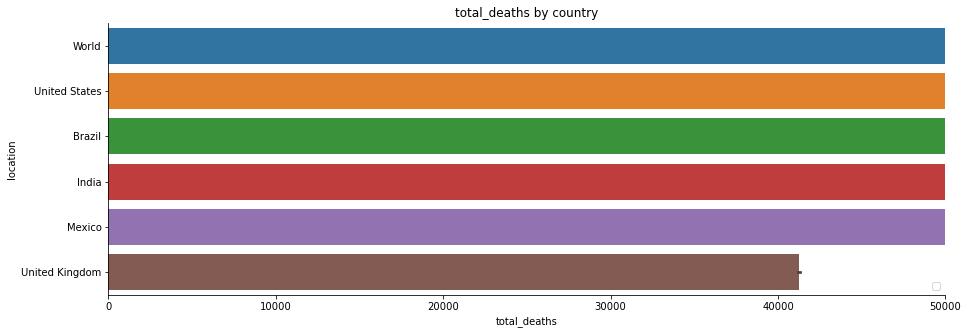

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


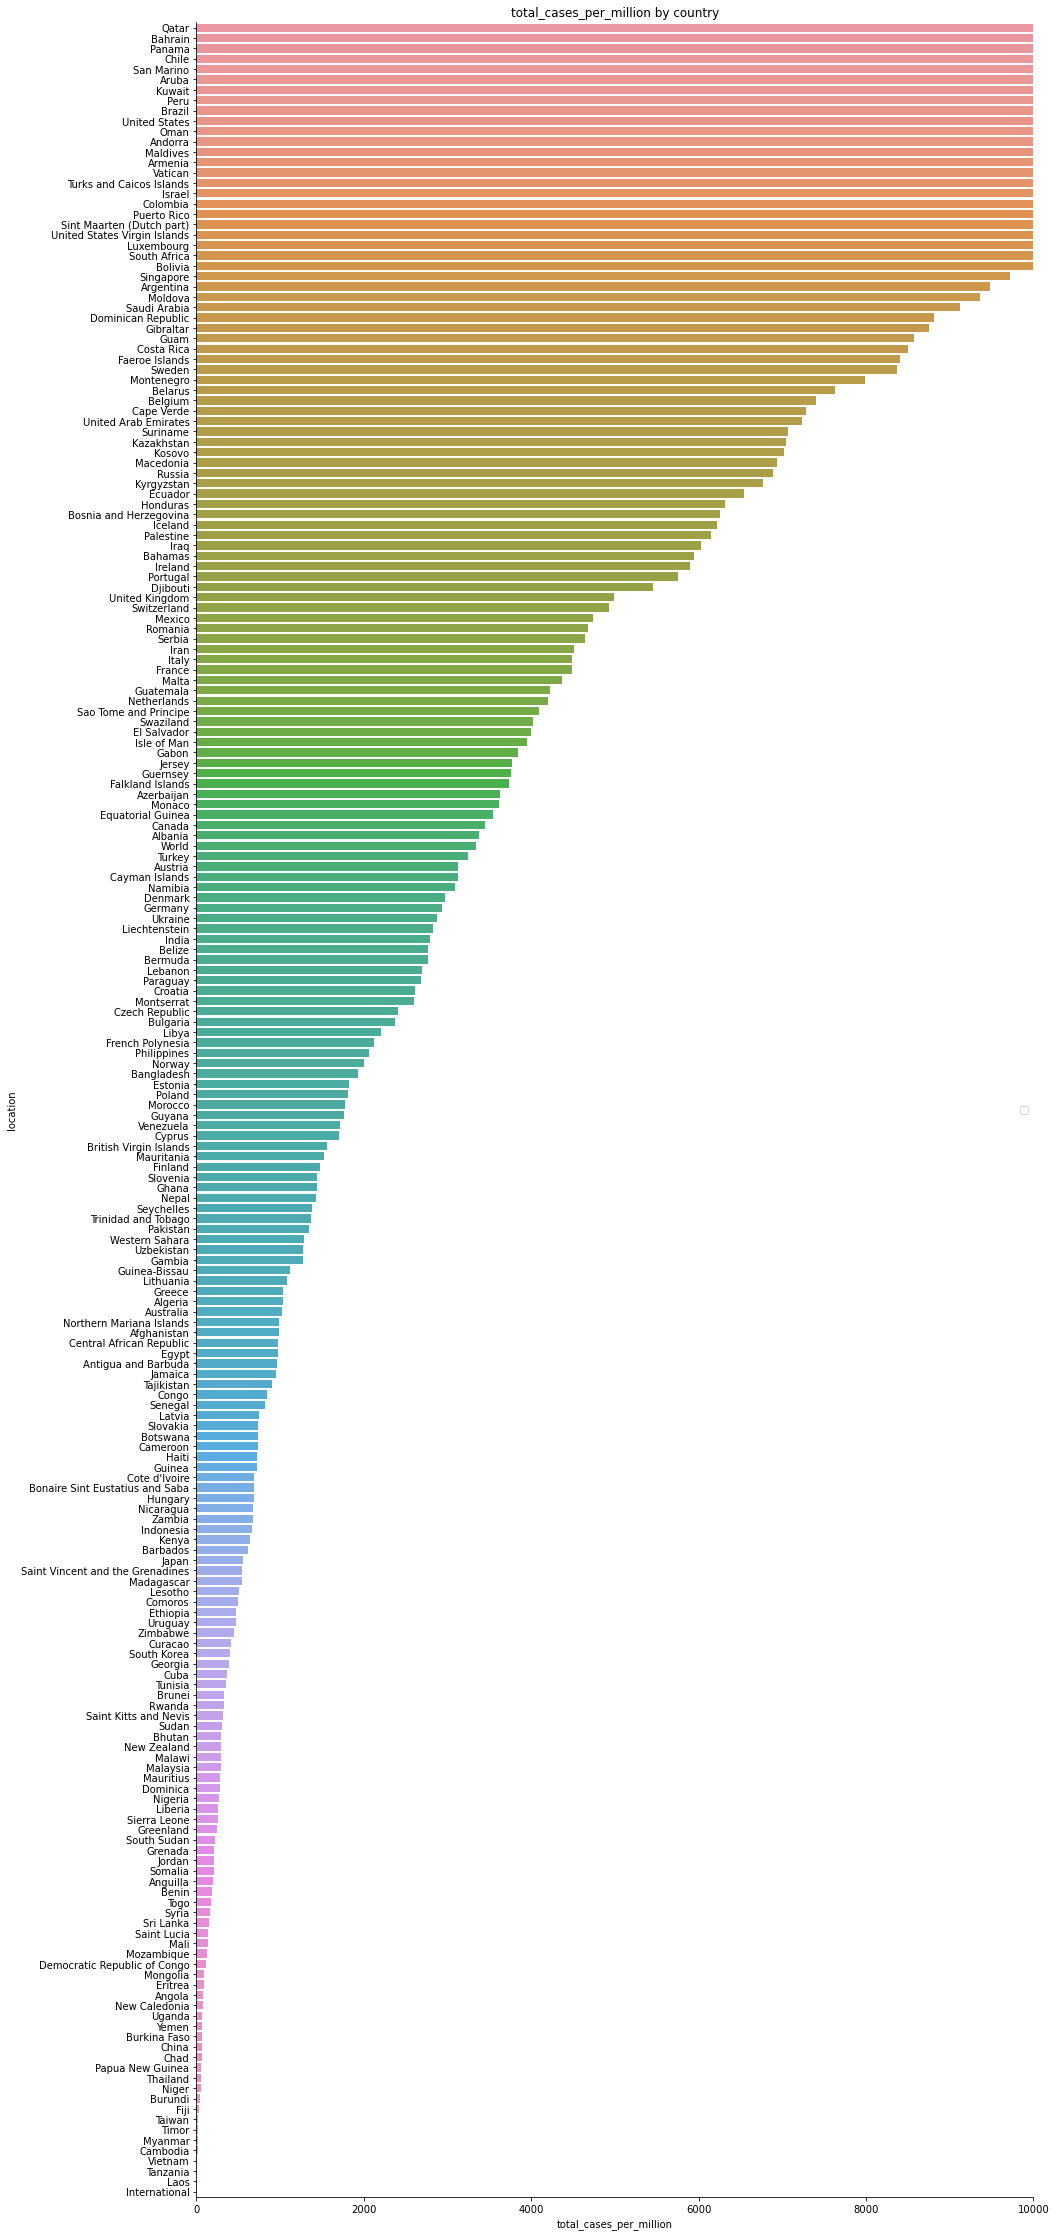

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


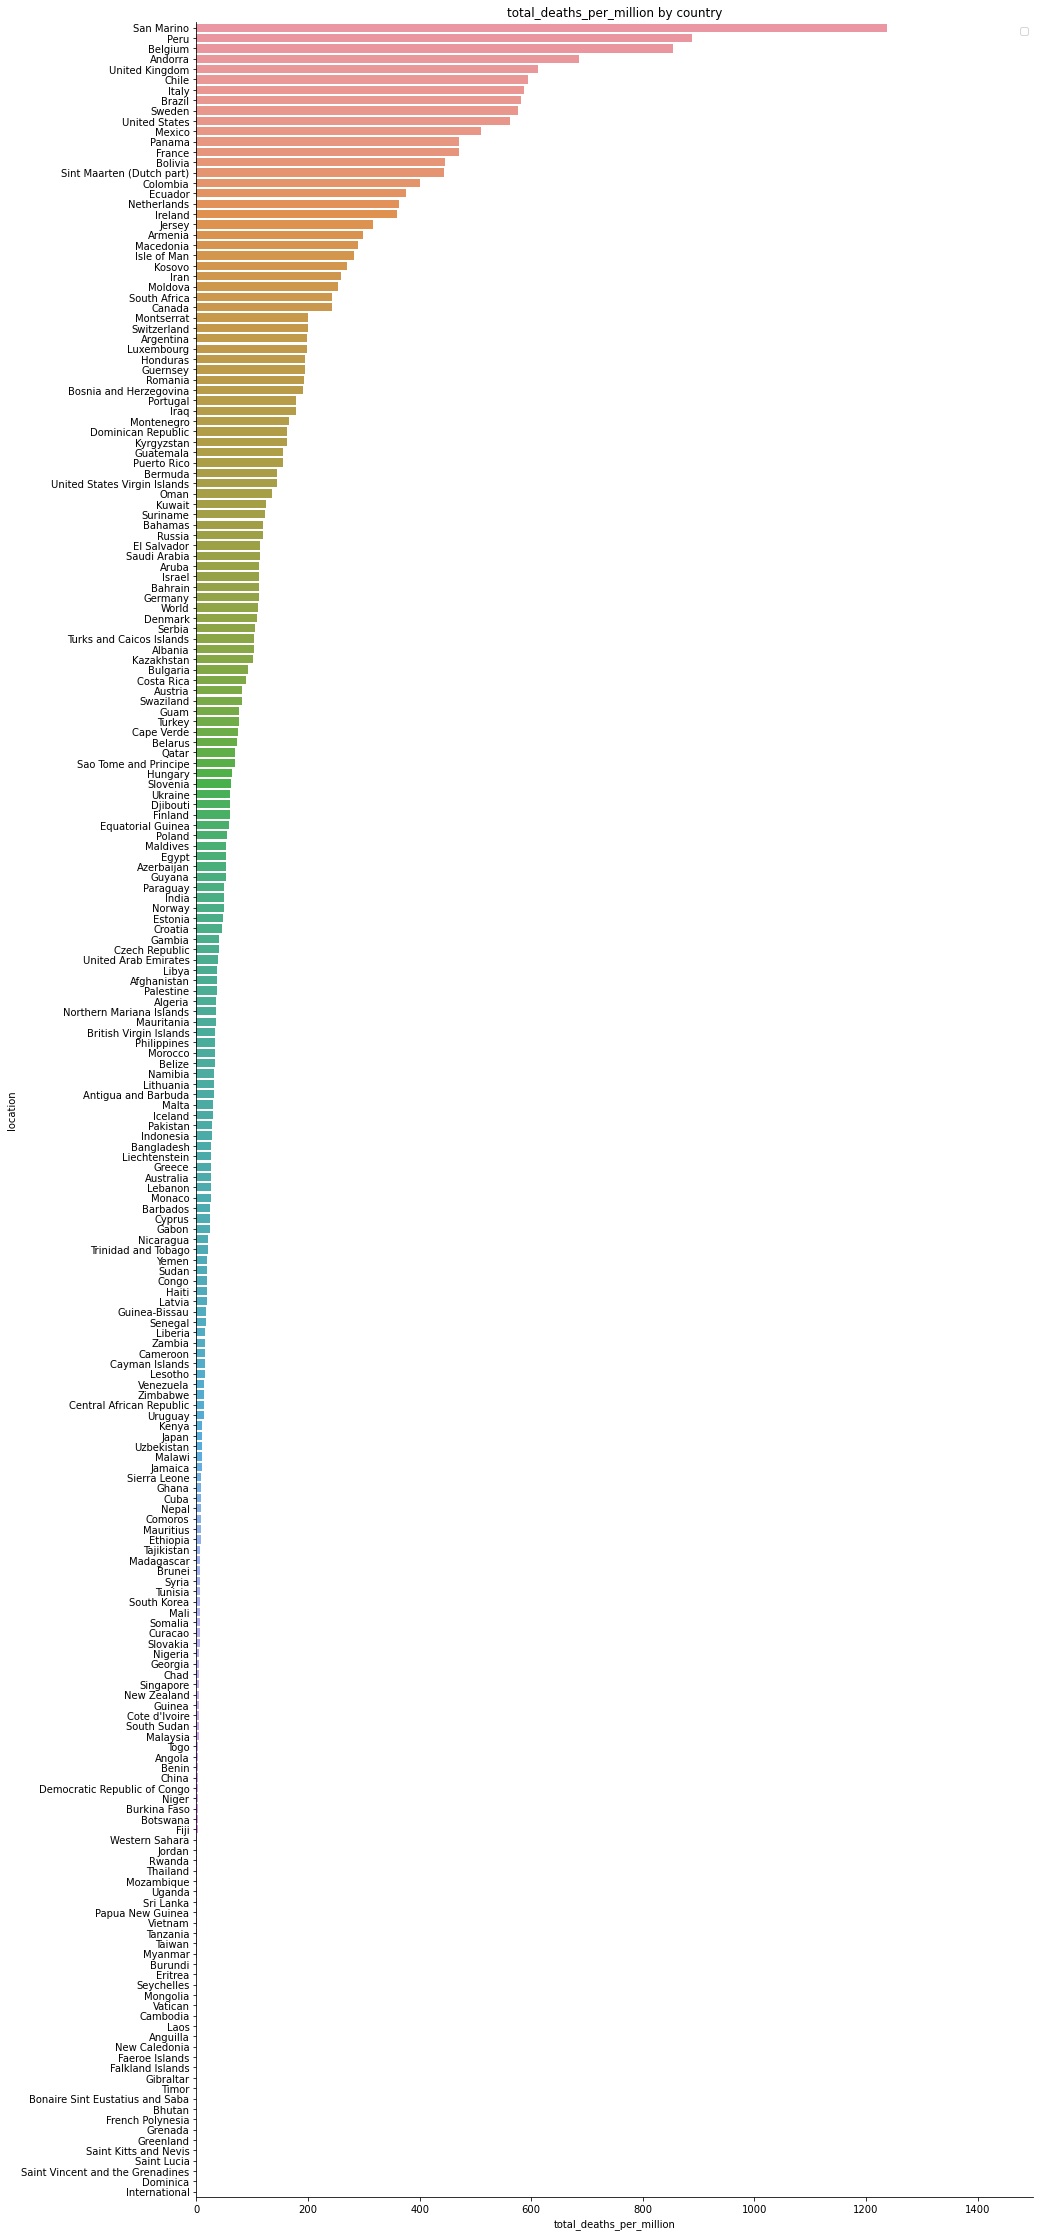

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

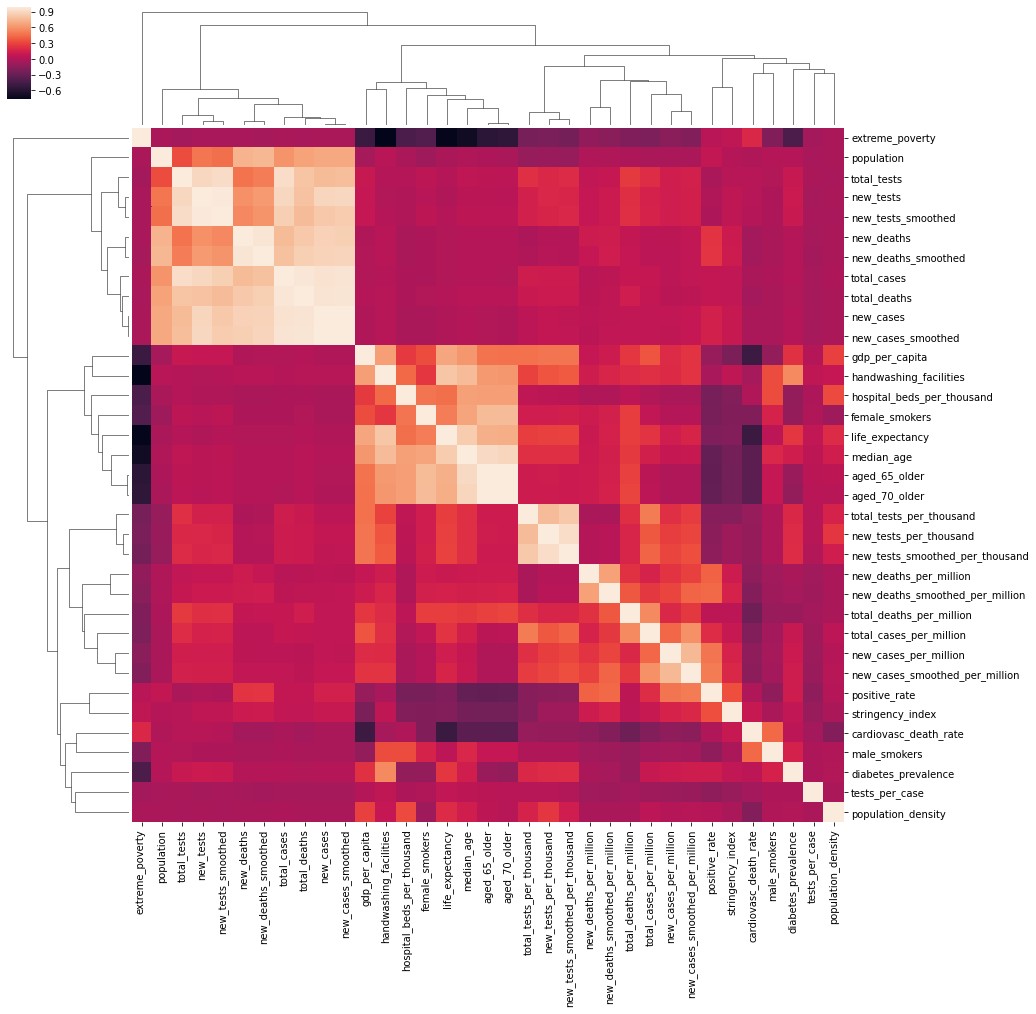

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9992675232193751 (+/- 0.0007028106027015827)
Coef :  [1.03643934e+00 9.29007580e-05 9.65288179e-05]
3 Last_days :  [[25517904 25785686 26059065]]
Today :  26059065
Prediction + :  479237
Tomorow :  26538302
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996741697318704 (+/- 5.8472130622835626e-05)
Coef :  [0.06548007 0.45782895 0.48681823]
3 Last_days :  [[850973 857497 863535]]
Today :  863535
Prediction + :  7832
Tomorow :  871367
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9867441882851398 (+/- 0.011888176522611753)
Coef :  [-0.70836503  0.75400722  0.9569672 ]
3 Last_days :  [[281025 286007 293024]]
Today :  293024
Prediction + :  4142
Tomorow :  297166
                                     
--------- Total Death -----------------
                                     
R^2: 0.4064968030763607 (+/- 0.8310155409681068)
Coef :  [-0.75164012  0.78868581  0.96198318]
3 Last_days :  [[30635 30661 30686]]
Today :  30686
Prediction + :  41
Tomorow :  30727
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9214305752466553 (+/- 0.06198966579608854)
Coef :  [-0.32557477 -0.01819577  1.33803765]
3 Last_days :  [[89914 89934 89953]]
Today :  89953
Prediction + :  25
Tomorow :  89978
                                     
--------- Total Death -----------------
                                     
R^2: -162.9455327833032 (+/- 231.72116476044346)
Coef :  [-0.07707529  0.01244457  1.05651622]
3 Last_days :  [[4723 4724 4727]]
Today :  4727
Prediction + :  6
Tomorow :  4733
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8263854669369923 (+/- 0.2444294084133526)
Coef :  [-0.82599566  0.89931176  0.92597049]
3 Last_days :  [[269214 270189 271515]]
Today :  271515
Prediction + :  900
Tomorow :  272415
                                     
--------- Total Death -----------------
                                     
R^2: 0.7580785946531802 (+/- 0.31535339337307605)
Coef :  [-0.82786882  0.89925001  0.92771978]
3 Last_days :  [[35483 35491 35497]]
Today :  35497
Prediction + :  27
Tomorow :  35524
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6348666313317474 (+/- 0.5065397359745764)
Coef :  [-0.46786721  0.2882312   1.18237213]
3 Last_days :  [[462858 470973 479554]]
Today :  479554
Prediction + :  6928
Tomorow :  486482
                                     
--------- Total Death -----------------
                                     
R^2: 0.1224600603056953 (+/- 1.0242295807074202)
Coef :  [-0.72573221  0.62740013  1.09733244]
3 Last_days :  [[29094 29152 29194]]
Today :  29194
Prediction + :  54
Tomorow :  29248
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9866131667737257 (+/- 0.018610806915520944)
Coef :  [0.07490185 0.46687162 0.4736174 ]
3 Last_days :  [[6031013 6075652 6114406]]
Today :  6114406
Prediction + :  83968
Tomorow :  6198374
                                     
--------- Total Death -----------------
                                     
R^2: 0.8348755881589097 (+/- 0.23231978573476972)
Coef :  [-0.52174683  0.72320497  0.80119576]
3 Last_days :  [[183598 184689 185744]]
Today :  185744
Prediction + :  1185
Tomorow :  186929
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9148737588871043 (+/- 0.11954465089443633)
Coef :  [-0.72711376  0.85139362  0.87589646]
3 Last_days :  [[335873 337168 338676]]
Today :  338676
Prediction + :  1343
Tomorow :  340019
                                     
--------- Total Death -----------------
                                     
R^2: 0.3659328466071008 (+/- 0.8587292947082568)
Coef :  [-0.77123589  0.83170815  0.93890774]
3 Last_days :  [[41501 41504 41514]]
Today :  41514
Prediction + :  38
Tomorow :  41552
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9798951092211886 (+/- 0.02606447318700391)
Coef :  [-0.79557471  0.85674518  0.93852993]
3 Last_days :  [[243599 244855 246116]]
Today :  246116
Prediction + :  1158
Tomorow :  247274
                                     
--------- Total Death -----------------
                                     
R^2: 0.3728480286330395 (+/- 0.8745095163990049)
Coef :  [-0.79059894  0.84099583  0.94891958]
3 Last_days :  [[9302 9313 9321]]
Today :  9321
Prediction + :  15
Tomorow :  9336
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.5037028543008784 (+/- 3.539357713679578)
Coef :  [0.2281049  0.39154817 0.39166983]
3 Last_days :  [[375212 376894 378752]]
Today :  378752
Prediction + :  4144
Tomorow :  382896
                                     
--------- Total Death -----------------
                                     
R^2: 0.9442833626770518 (+/- 0.07818234646532728)
Coef :  [0.01258011 0.50268386 0.49638347]
3 Last_days :  [[21571 21672 21797]]
Today :  21797
Prediction + :  242
Tomorow :  22039
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999314378766795 (+/- 0.0006613787523558711)
Coef :  [-0.727813    0.84424249  0.88094407]
3 Last_days :  [[270133 271705 273301]]
Today :  273301
Prediction + :  1286
Tomorow :  274587
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991489050214161 (+/- 0.0006412976457559898)
Coef :  [-0.80999181  0.89243867  0.91481995]
3 Last_days :  [[6370 6417 6462]]
Today :  6462
Prediction + :  38
Tomorow :  6500
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.45371058848065243 (+/- 0.7687716346211177)
Coef :  [-0.12890855  0.4990306   0.64606285]
3 Last_days :  [[3908272 3950931 3997865]]
Today :  3997865
Prediction + :  59410
Tomorow :  4057275
                                     
--------- Total Death -----------------
                                     
R^2: 0.4897233118282953 (+/- 0.7189284915338869)
Coef :  [-0.10871344  0.51821337  0.60277671]
3 Last_days :  [[121381 122596 123780]]
Today :  123780
Prediction + :  1433
Tomorow :  125213
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(26059065, 863535, 26538302, 871367),
 (293024, 30686, 297166, 30727),
 (271515, 35497, 272415, 35524),
 (479554, 29194, 486482, 29248),
 (6114406, 185744, 6198374, 186929),
 (89953, 4727, 89978, 4733),
 (338676, 41514, 340019, 41552),
 (246116, 9321, 247274, 9336),
 (378752, 21797, 382896, 22039),
 (273301, 6462, 274587, 6500),
 (3997865, 123780, 4057275, 125213)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-03,France,297166.0,0.0,30727.0,0.0,0.0,0.0
0,2020-09-03,China,89978.0,0.0,4733.0,0.0,0.0,0.0
0,2020-09-03,Italy,272415.0,0.0,35524.0,0.0,0.0,0.0
0,2020-09-03,Spain,486482.0,0.0,29248.0,0.0,0.0,0.0
0,2020-09-03,United States,6198374.0,0.0,186929.0,0.0,0.0,0.0
0,2020-09-03,World,26538302.0,0.0,871367.0,0.0,0.0,0.0
0,2020-09-03,United Kingdom,340019.0,0.0,41552.0,0.0,0.0,0.0
0,2020-09-03,Germany,247274.0,0.0,9336.0,0.0,0.0,0.0
0,2020-09-03,Iran,382896.0,0.0,22039.0,0.0,0.0,0.0
0,2020-09-03,Turkey,274587.0,0.0,6500.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")